In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)        # 기본 폰트 크기
plt.rc('axes', labelsize=14)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=14)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=14)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=14)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

In [2]:
import os
import os.path as osp
import random
import argparse
import yaml
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms

import clip

from torch.cuda.amp import GradScaler, autocast

OUTPUT_DIR = '/data4/kchanwo/clipall/clipall/analysis'

In [3]:
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)
device

'cuda'

In [4]:
import pickle

domains = {
    'PACS': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'VLCS': ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007'],
    'office_home': ['Art', 'Clipart', 'Product', 'Real World'],
    'terra_incognita': ['location_43', 'location_46', 'location_38', 'location_100']
}
class_names = {
    'PACS': ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'],
    'VLCS': ['bird', 'car', 'chair', 'dog', 'person'],
    'office_home': sorted(['Bottle', 'Pencil', 'Folder', 'Refrigerator', 'Mop', 'Spoon', 'Backpack', 'Flipflops', 'Fork', 'Laptop', 'Keyboard', 'Sneakers', 'Webcam', 'Telephone', 'Bed', 'Batteries', 'Alarm_Clock', 'Mouse', 'Calculator', 'Candles', 'Clipboards', 'Marker', 'TV', 'Shelf', 'Push_Pin', 'Drill', 'Couch', 'Lamp_Shade', 'Pen', 'Postit_Notes', 'Calendar', 'Printer', 'Fan', 'Mug', 'Table', 'Desk_Lamp', 'Monitor', 'Speaker', 'Glasses', 'Helmet', 'File_Cabinet', 'Pan', 'Exit_Sign', 'Trash_Can', 'Bucket', 'Hammer', 'Notebook', 'Toys', 'Chair', 'Ruler', 'ToothBrush', 'Bike', 'Curtains', 'Soda', 'Screwdriver', 'Knives', 'Oven', 'Paper_Clip', 'Kettle', 'Scissors', 'Computer', 'Eraser', 'Sink', 'Flowers', 'Radio']),
    'terra_incognita': sorted(['opossum', 'cat', 'bobcat', 'dog', 'squirrel', 'rabbit', 'coyote', 'raccoon', 'bird', 'empty'])
}

with open('errorcases.pkl', 'rb') as fr:
    g_errorcases = pickle.load(fr)

In [6]:
dataset = 'PACS'

err_df = pd.DataFrame(g_errorcases[dataset])
display(err_df.head())
display(err_df.domain.value_counts())
print(err_df.shape)

# 시각화파트 출력하려면 아래를 True로
visualize = False

if(visualize):
    fig, axs = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        if i == len(err_df[err_df.domain == domains[dataset][0]]): break
        axs[i].imshow(Image.open(err_df[err_df.domain == domains[dataset][0]].iloc[i].file_path))
        axs[i].set_title(str(class_names[dataset][err_df[err_df.domain == domains[dataset][0]].iloc[i].preds[-1]])+' but '+
                         str(class_names[dataset][err_df[err_df.domain == domains[dataset][0]].iloc[i].target]))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        print(err_df[err_df.domain == domains[dataset][0]].iloc[i].file_path)
    # fig.suptitle(f"Layer: sketch")
    plt.show()
    
    fig, axs = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        if i == len(err_df[err_df.domain == domains[dataset][1]]): break
        axs[i].imshow(Image.open(err_df[err_df.domain == domains[dataset][1]].iloc[i].file_path))
        axs[i].set_title(str(class_names[dataset][err_df[err_df.domain == domains[dataset][1]].iloc[i].preds[-1]])+' but '+
                         str(class_names[dataset][err_df[err_df.domain == domains[dataset][1]].iloc[i].target]))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        print(err_df[err_df.domain == domains[dataset][1]].iloc[i].file_path)
    # fig.suptitle(f"Layer: art_painting")
    plt.show()
    
    fig, axs = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        if i == len(err_df[err_df.domain == domains[dataset][2]]): break
        axs[i].imshow(Image.open(err_df[err_df.domain == domains[dataset][2]].iloc[i].file_path))
        axs[i].set_title(str(class_names[dataset][err_df[err_df.domain == domains[dataset][2]].iloc[i].preds[-1]])+' but '+
                         str(class_names[dataset][err_df[err_df.domain == domains[dataset][2]].iloc[i].target]))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        print(err_df[err_df.domain == domains[dataset][2]].iloc[i].file_path)
    # fig.suptitle(f"Layer: cartoon")
    plt.show()
    
    fig, axs = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        if i < len(err_df[err_df.domain == domains[dataset][3]]):
            axs[i].imshow(Image.open(err_df[err_df.domain == domains[dataset][3]].iloc[i].file_path))
            axs[i].set_title(str(class_names[dataset][err_df[err_df.domain == domains[dataset][3]].iloc[i].preds[-1]])+' but '+
                         str(class_names[dataset][err_df[err_df.domain == domains[dataset][3]].iloc[i].target]))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        print(err_df[err_df.domain == domains[dataset][3]].iloc[i].file_path)
    # fig.suptitle(f"Layer: photo")
    plt.show()

,file_path,domain,target,preds
0,/data4/kchanwo/clipall/datasets/PACS/art_paint...,art_painting,0,"[0, 0, 2, 6, 6, 6, 0, 0, 6, 6, 6, 6]"
1,/data4/kchanwo/clipall/datasets/PACS/art_paint...,art_painting,0,"[0, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
2,/data4/kchanwo/clipall/datasets/PACS/art_paint...,art_painting,0,"[0, 0, 2, 4, 4, 4, 4, 4, 4, 6, 4, 4]"
3,/data4/kchanwo/clipall/datasets/PACS/art_paint...,art_painting,0,"[1, 0, 5, 4, 4, 4, 4, 4, 6, 4, 4, 4]"
4,/data4/kchanwo/clipall/datasets/PACS/art_paint...,art_painting,0,"[2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"


domain
sketch          467
art_painting     52
cartoon          22
photo             1
Name: count, dtype: int64

(542, 4)


In [7]:
for i in range(12):
    err_df[f'pred_{i}'] = err_df.apply(lambda x: x['preds'][i] == x['target'], axis=1)
display(err_df.drop(['file_path', 'domain'], axis=1).head())

x = [x+1 for x in range(12)]
y = [err_df[f'pred_{i}'].sum() for i in range(12)]

if visualize:
    plt.figure(figsize=(15, 6))
    plt.bar(x, y, color='gray')
    plt.xticks(x)
    plt.ylim(0,max(y)+50)
    for i, v in enumerate(x):
        plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
                 fontsize = 14, 
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    plt.savefig(f'{OUTPUT_DIR}/errcase/output.png', bbox_inches='tight')
    plt.show()
    plt.close()

,target,preds,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11
0,0,"[0, 0, 2, 6, 6, 6, 0, 0, 6, 6, 6, 6]",True,True,False,False,False,False,True,True,False,False,False,False
1,0,"[0, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6]",True,False,False,False,False,False,False,False,False,False,False,False
2,0,"[0, 0, 2, 4, 4, 4, 4, 4, 4, 6, 4, 4]",True,True,False,False,False,False,False,False,False,False,False,False
3,0,"[1, 0, 5, 4, 4, 4, 4, 4, 6, 4, 4, 4]",False,True,False,False,False,False,False,False,False,False,False,False
4,0,"[2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]",False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()    
        self.transformer = clip_model.transformer
        self.token_embedding = clip_model.token_embedding
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.dtype = clip_model.dtype
        self.text_projection = clip_model.text_projection.cuda()
        
    def forward(self, text):
        out_list = []
        x = self.token_embedding(text).type(self.dtype)
        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        for i in range(self.transformer.layers):
            x = self.transformer.resblocks[i](x)
            tmp = x.permute(1, 0, 2)            # LND -> NLD
            tmp = self.ln_final(tmp).type(self.dtype)
            tmp = tmp[torch.arange(tmp.shape[0]), text.argmax(dim=-1)] @ self.text_projection
            out_list.append(tmp)
        text_features = torch.stack(out_list)
        return text_features
    
class ImageEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.conv1 = clip_model.visual.conv1
        self.transformer = clip_model.visual.transformer
        self.class_embedding = clip_model.visual.class_embedding
        self.positional_embedding = clip_model.visual.positional_embedding
        self.ln_pre = clip_model.visual.ln_pre
        self.ln_post = clip_model.visual.ln_post
        self.dtype = clip_model.dtype        
        self.image_projection = clip_model.visual.proj.cuda()
        
    def forward(self, image):
        out_list = []        
        x = self.conv1(image)
        x = x.reshape(x.shape[0], x.shape[1], -1)   # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)                      # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + 
                    torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)
        x = x.permute(1, 0, 2)          # NLD -> LND
        for i in range(self.transformer.layers):
            x = self.transformer.resblocks[i](x)
            tmp = x.permute(1, 0, 2)    # LND -> NLD
            tmp = self.ln_post(tmp[:, 0, :])
            tmp = tmp @ self.image_projection    # NLD -> NLD_output
            out_list.append(tmp)
        image_features = torch.stack(out_list)
        
        return image_features

In [6]:
image_encoder = ImageEncoder(model)
text_encoder = TextEncoder(model)

In [25]:
# g_errorcases['PACS'][0]
g_errorcases = {
    'PACS': [],
    'VLCS': [],
    'office_home': [],
    'terra_incognita': [],
}

In [84]:
from tqdm import tqdm
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

softmax = nn.Softmax(dim=0)
path = '/data4/kchanwo/clipall/datasets'

def classify(dataset, domains, class_names):
    global g_errorcases
    if len(g_errorcases[dataset]) > 0: 
        print("already exists!")
        return g_errorcases[dataset]

    # text feature extract
    text = clip.tokenize([f'a photo of a {name}' for name in class_names]).to(device)
    text_features = model.encode_text(text)
    # text_features = text_encoder(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # collect errorcases
    errorcases = [
        # {"file_path":"", "domain":'', 'target':None, 'preds': []}
    ]

    for domain in os.listdir(f"{path}/{dataset}/"):
        title, ext = os.path.splitext(domain)
        if ext : continue;
            
        for i_class, class_name in enumerate(tqdm(os.listdir(f"{path}/{dataset}/{domain}/"))):
            
            for file in os.listdir(f"{path}/{dataset}/{domain}/{class_name}"):
                title, ext = os.path.splitext(file)
                if ext != '.jpg' and ext !='.png': continue;
                    
                image = preprocess(Image.open(f"{path}/{dataset}/{domain}/{class_name}/{file}")).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    image_features = image_encoder(image.type(model.dtype))
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

                    # image_features : 12, 1, 512
                    # text_features : 12, 7, 512 (PACS)

                    preds = []
                    pred_logits = []
                    pred_probs = []
                    for i, image_features_per_layer in enumerate(image_features): # 레이어 별로
                        logit = model.logit_scale.exp() * image_features_per_layer @ text_features.t() # 12, 1, 7
                        prob = logit.softmax(dim=-1) # 12, 1, 7
                        pred = prob.argmax(-1).cpu().numpy()[0] # 12, 1
                        pred_logit = logit.squeeze()[pred].cpu().tolist()
                        pred_prob = prob.squeeze()[pred].cpu().tolist()
                        preds.append(pred)
                        pred_logits.append(pred_logit)
                        pred_probs.append(pred_prob)
                    last_pred = (
                        preds[-1], 
                        preds[np.argmax(pred_logits)],
                        preds[np.argmax(pred_probs)]
                    )
                    if last_pred[0] != i_class : # or last_pred[1] != i_class or last_pred[2] != i_class:
                        errorcases.append({
                            "file_path": f"{path}/{dataset}/{domain}/{class_name}/{file}",
                            "domain": domain,
                            "target": i_class,
                            "preds": preds,
                            "pred_logits": pred_logits,
                            "pred_probs": pred_probs,
                            'pred_method_0': last_pred[0] == i_class,
                            'pred_method_1': last_pred[1] == i_class,
                            'pred_method_2': last_pred[2] == i_class,
                        })
    return errorcases
err = classify('office_home', domains['office_home'], class_names['office_home']) # 약 4분 소요
len(err)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [03:19<00:00,  3.07s/it]


15392

In [80]:
[k for k in err_df.drop(['file_path', 'domain'], axis=1)[err_df[f'pred_0']].pred_probs.map(lambda x: [np.round(y, 2) for y in x])]

[[0.76, 0.75, 0.77, 0.82, 0.81, 0.82, 0.86, 0.95, 0.97, 0.97, 0.97, 0.97],
 [0.74, 0.73, 0.75, 0.78, 0.78, 0.86, 0.91, 0.96, 0.98, 0.96, 0.98, 0.9],
 [0.72, 0.73, 0.69, 0.77, 0.77, 0.71, 0.75, 0.82, 0.9, 0.92, 0.96, 0.72],
 [0.74, 0.75, 0.72, 0.8, 0.81, 0.78, 0.8, 0.82, 0.9, 0.88, 0.9, 0.57],
 [0.75, 0.75, 0.76, 0.76, 0.7, 0.72, 0.64, 0.77, 0.79, 0.71, 0.88, 0.7],
 [0.73, 0.74, 0.66, 0.73, 0.78, 0.79, 0.8, 0.87, 0.94, 0.93, 0.96, 0.92],
 [0.79, 0.75, 0.75, 0.79, 0.79, 0.89, 0.87, 0.89, 0.95, 0.94, 0.96, 0.5],
 [0.79, 0.75, 0.76, 0.84, 0.83, 0.9, 0.88, 0.88, 0.95, 0.9, 0.92, 0.59],
 [0.76, 0.73, 0.71, 0.75, 0.75, 0.86, 0.82, 0.93, 0.93, 0.89, 0.9, 0.66],
 [0.74, 0.73, 0.74, 0.8, 0.78, 0.83, 0.74, 0.89, 0.96, 0.91, 0.92, 0.56],
 [0.79, 0.75, 0.75, 0.84, 0.7, 0.8, 0.61, 0.81, 0.92, 0.8, 0.89, 0.45],
 [0.78, 0.74, 0.75, 0.82, 0.82, 0.83, 0.88, 0.9, 0.95, 0.88, 0.84, 0.54],
 [0.73, 0.73, 0.73, 0.75, 0.73, 0.88, 0.86, 0.93, 0.96, 0.81, 0.85, 0.5],
 [0.73, 0.74, 0.73, 0.75, 0.71, 0.8, 0.81, 0

,target,preds,pred_logits,pred_probs,pred_method_0,pred_method_1,pred_method_2,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11
117,2,"[2, 2, 2, 2, 2, 2, 34, 34, 34, 34, 34, 15]","[31.421875, 31.796875, 32.53125, 32.5, 30.6406...","[0.197021484375, 0.247802734375, 0.48266601562...",False,True,False,True,True,True,True,True,True,False,False,False,False,False,False
119,2,"[2, 2, 2, 2, 2, 2, 2, 2, 21, 21, 21, 61]","[31.78125, 31.734375, 32.75, 32.6875, 31.21875...","[0.212890625, 0.192138671875, 0.330810546875, ...",False,True,False,True,True,True,True,True,True,True,True,False,False,False,False
121,2,"[2, 2, 2, 2, 2, 2, 34, 2, 34, 34, 21, 15]","[31.625, 31.9375, 32.875, 32.625, 30.796875, 3...","[0.201416015625, 0.205078125, 0.365234375, 0.3...",False,True,False,True,True,True,True,True,True,False,True,False,False,False,False
123,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 34, 21, 15]","[31.578125, 31.96875, 33.03125, 32.78125, 30.7...","[0.1865234375, 0.192138671875, 0.340576171875,...",False,True,False,True,True,True,True,True,True,True,True,True,False,False,False
124,2,"[2, 2, 2, 2, 2, 2, 33, 21, 34, 34, 21, 24]","[31.9375, 32.28125, 33.1875, 32.96875, 31.2343...","[0.2122802734375, 0.2225341796875, 0.359619140...",False,True,False,True,True,True,True,True,True,False,False,False,False,False,False


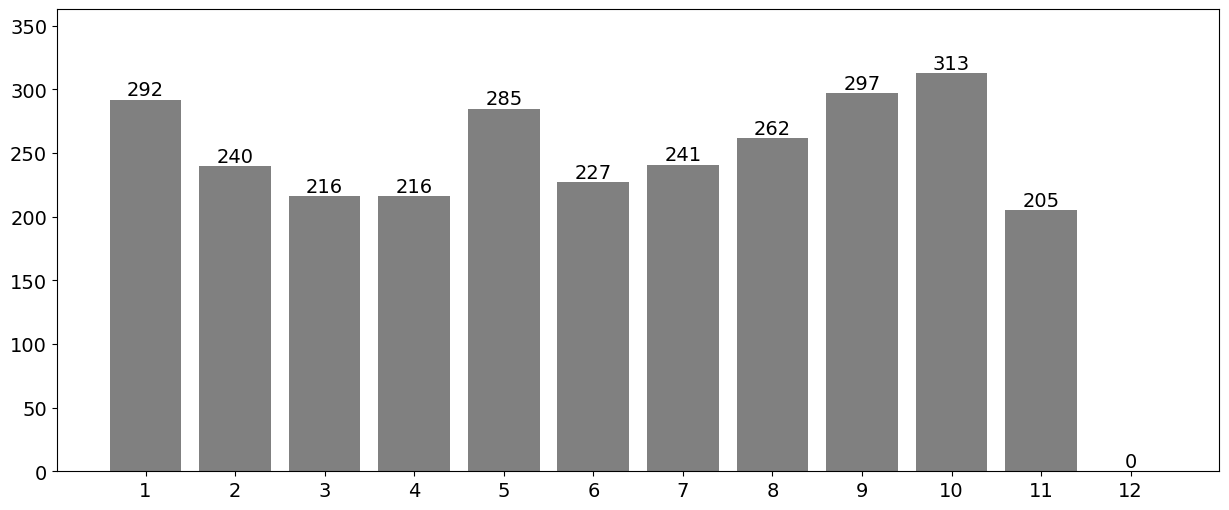

In [85]:
err_df = pd.DataFrame(err)

for i in range(12):
    err_df[f'pred_{i}'] = err_df.apply(lambda x: x['preds'][i] == x['target'], axis=1)
display(err_df.drop(['file_path', 'domain'], axis=1)[err_df[f'pred_0']].head())

x = [x+1 for x in range(12)]
y = [err_df[f'pred_{i}'].sum() for i in range(12)]

if True:
    plt.figure(figsize=(15, 6))
    plt.bar(x, y, color='gray')
    plt.xticks(x)
    plt.ylim(0,max(y)+50)
    for i, v in enumerate(x):
        plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
                 fontsize = 14, 
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    # plt.savefig(f'{OUTPUT_DIR}/errcase/output.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [55]:
from tqdm import tqdm
import os

softmax = nn.Softmax(dim=0)
path = '/data4/kchanwo/clipall/datasets'

def classify(dataset, domains, class_names):
    global g_errorcases
    if len(g_errorcases[dataset]) > 0: 
        print("already exists!")
        return g_errorcases[dataset]

    # text feature extract
    text = clip.tokenize([f'a photo of a {name}' for name in class_names]).to(device)
    text_features = text_encoder(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # collect errorcases
    errorcases = [
        # {"file_path":"", "domain":'', 'target':None, 'preds': []}
    ]

    for domain in os.listdir(f"{path}/{dataset}/"):
        title, ext = os.path.splitext(domain)
        if ext : continue;
            
        for i_class, class_name in enumerate(tqdm(os.listdir(f"{path}/{dataset}/{domain}/"))):
            
            for file in os.listdir(f"{path}/{dataset}/{domain}/{class_name}"):
                title, ext = os.path.splitext(file)
                if ext != '.jpg' and ext !='.png': continue;
                    
                image = preprocess(Image.open(f"{path}/{dataset}/{domain}/{class_name}/{file}")).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    image_features = image_encoder(image.type(model.dtype))
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

                    # image_features : 12, 1, 512
                    # text_features : 12, 7, 512 (PACS)

                    preds = []
                    pred_logits = []
                    pred_probs = []
                    for i, text_features_per_layer in enumerate(text_features): # 레이어 별로
                        logit = model.logit_scale.exp() * image_features @ text_features_per_layer.t() # 12, 1, 7
                        prob = logit.softmax(dim=-1) # 12, 1, 7
                        pred = prob.argmax(-1).cpu().numpy()[0] # 12, 1
                        pred_logit = logit.squeeze()[pred].cpu().tolist()
                        pred_prob = prob.squeeze()[pred].cpu().tolist()
                        preds.append(pred)
                        pred_logits.append(pred_logit)
                        pred_probs.append(pred_prob)
                    last_pred = (
                        preds[-1], 
                        preds[np.argmax(pred_logits)],
                        preds[np.argmax(pred_probs)]
                    )
                    if last_pred[0] != i_class or last_pred[1] != i_class or last_pred[2] != i_class:
                        errorcases.append({
                            "file_path": f"{path}/{dataset}/{domain}/{class_name}/{file}",
                            "domain": domain,
                            "target": i_class,
                            "preds": preds,
                            "pred_logits": pred_logits,
                            "pred_probs": pred_probs,
                            'pred_method_0': last_pred[0] == i_class,
                            'pred_method_1': last_pred[1] == i_class,
                            'pred_method_2': last_pred[2] == i_class,
                        })
    return errorcases
err = classify('PACS', domains['PACS'], class_names['PACS']) # 약 4분 소요
len(err)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:01<00:00,  8.77s/it]


766

In [56]:
df = pd.DataFrame(err)
df.pred_method_0.sum(), df.pred_method_1.sum(), df.pred_method_2.sum()

(224, 105, 94)

In [54]:
df[(df.pred_method_1 == False) & df.pred_method_2].shape

(81, 9)